python3 SpikeCounter/cluster/run_preprocess_stim_jobs2.py /n/holyscratch01/cohen_lab/bjia/20210929_widefield_hcn4mo/ None --remove_from_start 1 --remove_from_end 1 --n_pcs=40 --scale_factor=2 --skewness_threshold 1 --denoise 1 --decorrelate 1 --start_from_downsampled 0 > jobs3.txt



In [1]:
import sys
from pathlib import Path
import os
import warnings
SPIKECOUNTER_PATH = os.getenv("SPIKECOUNTER_PATH")
sys.path.append(SPIKECOUNTER_PATH)
import matplotlib as mpl
from matplotlib import patches, colors
import colorcet as cc
from cycler import cycler

import numpy as np
import skimage.io as skio
from scipy import ndimage, signal, stats, fft, interpolate, optimize
from scipy.io import savemat
from skimage import exposure, measure, filters, transform, morphology
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import time
import mat73
import pandas as pd
import parse
import pickle

from spikecounter.analysis import traces, images
from spikecounter.ui import visualize, HyperStackViewer
from spikecounter import utils
import seaborn as sns


warnings.filterwarnings("once")
plt.style.use(
    os.path.join(SPIKECOUNTER_PATH, "config", "bio_publications.mplstyle")
)
ss = StandardScaler()

In [2]:
expt_dir_name = "20210929_widefield_hcn4mo"
rootdir = Path(os.getenv("DATA_ROOTDIR"), expt_dir_name)
output_datadir = Path(os.getenv("ANALYSIS_OUTPUT_ROOTDIR"), "2022 First Heartbeat_Submitted", 
                       "Figures/Data/Figure3/", expt_dir_name)
os.makedirs(output_datadir, exist_ok=True)
subfolder = "corrected"

In [3]:
fs=10.2
start_hpf = 19.75
expt_info = utils.process_experiment_metadata(pd.read_csv(Path(rootdir,"analysis", subfolder, "experiment_data.csv")))
expt_info["hpf"] = start_hpf + expt_info["offset"]/3600

### Plot masks

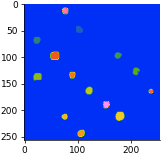

In [4]:
segmentation_mask = skio.imread(rootdir/subfolder/"analysis/segmentation_video.tif")
roi_map = np.median(segmentation_mask, axis=0)
roi_map = roi_map[np.arange(roi_map.shape[0], step=2),:]
roi_map = roi_map[:,np.arange(roi_map.shape[1], step=2)]
plt.imshow(roi_map)

In [5]:
def custom_lp_filter(raw, norm_thresh=0.5):
    b, a = signal.butter(5, norm_thresh)
    intensity = signal.filtfilt(b, a, raw)
    mean_freq = 2.0
    b, a = signal.butter(5, [mean_freq-0.2, mean_freq+0.2], btype="bandstop", fs=10.2)
    intensity = signal.filtfilt(b, a, intensity)
    return intensity

In [6]:
dobj = traces.TimelapseArrayExperiment(os.path.join(rootdir, subfolder, "analysis"),start_hpf, fs)

In [7]:
dobj.load_traces(timepoints=np.arange(1, expt_info.shape[0], dtype=int), per_trace_start=0, pb_window=401, corr_photobleach=False)

In [8]:
dobj.analyze_peaks(threshold=0.008, prominence="snr", auto_prom_scale=3, auto_thresh_scale=0.4, \
                   wlen=20, min_width=3, max_width=30, baseline_duration=200, baseline_start=10,\
                  excl=210)

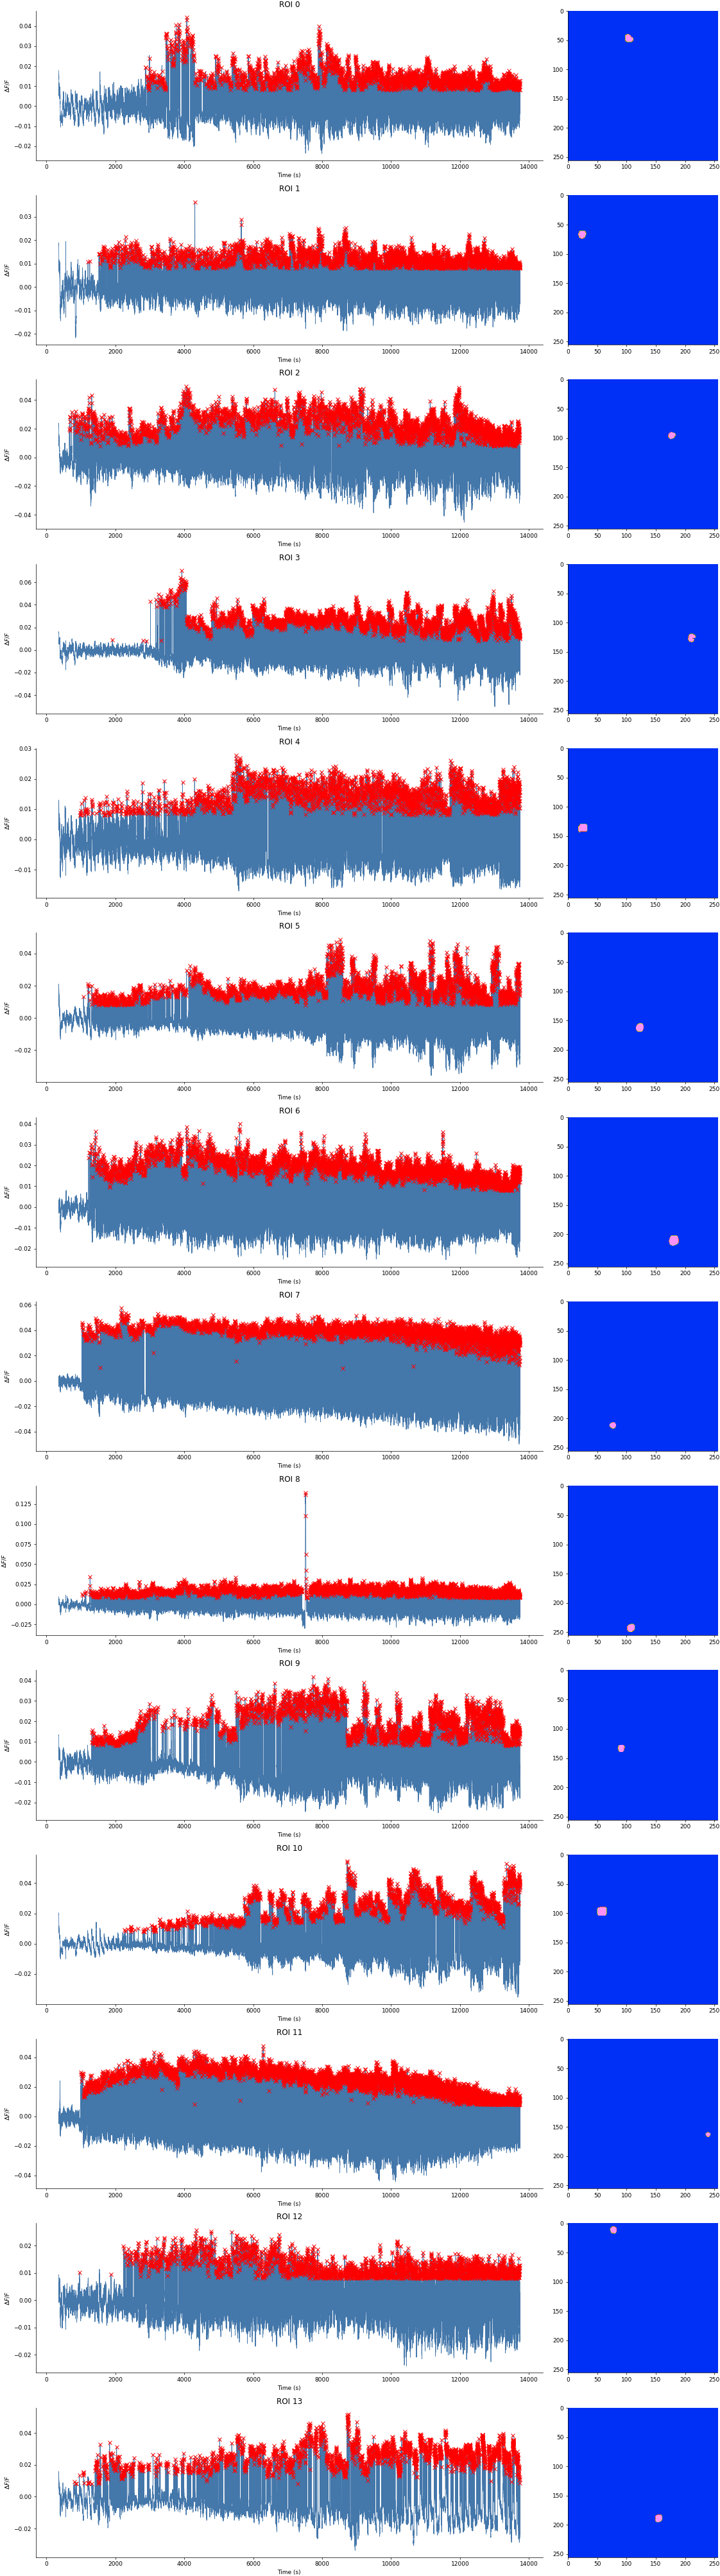

In [71]:
plt.close("all")
fig1, axes = dobj.plot_spikes_with_mask(roi_map)
plt.savefig(os.path.join(rootdir, "analysis", "spikeplots.svg"))

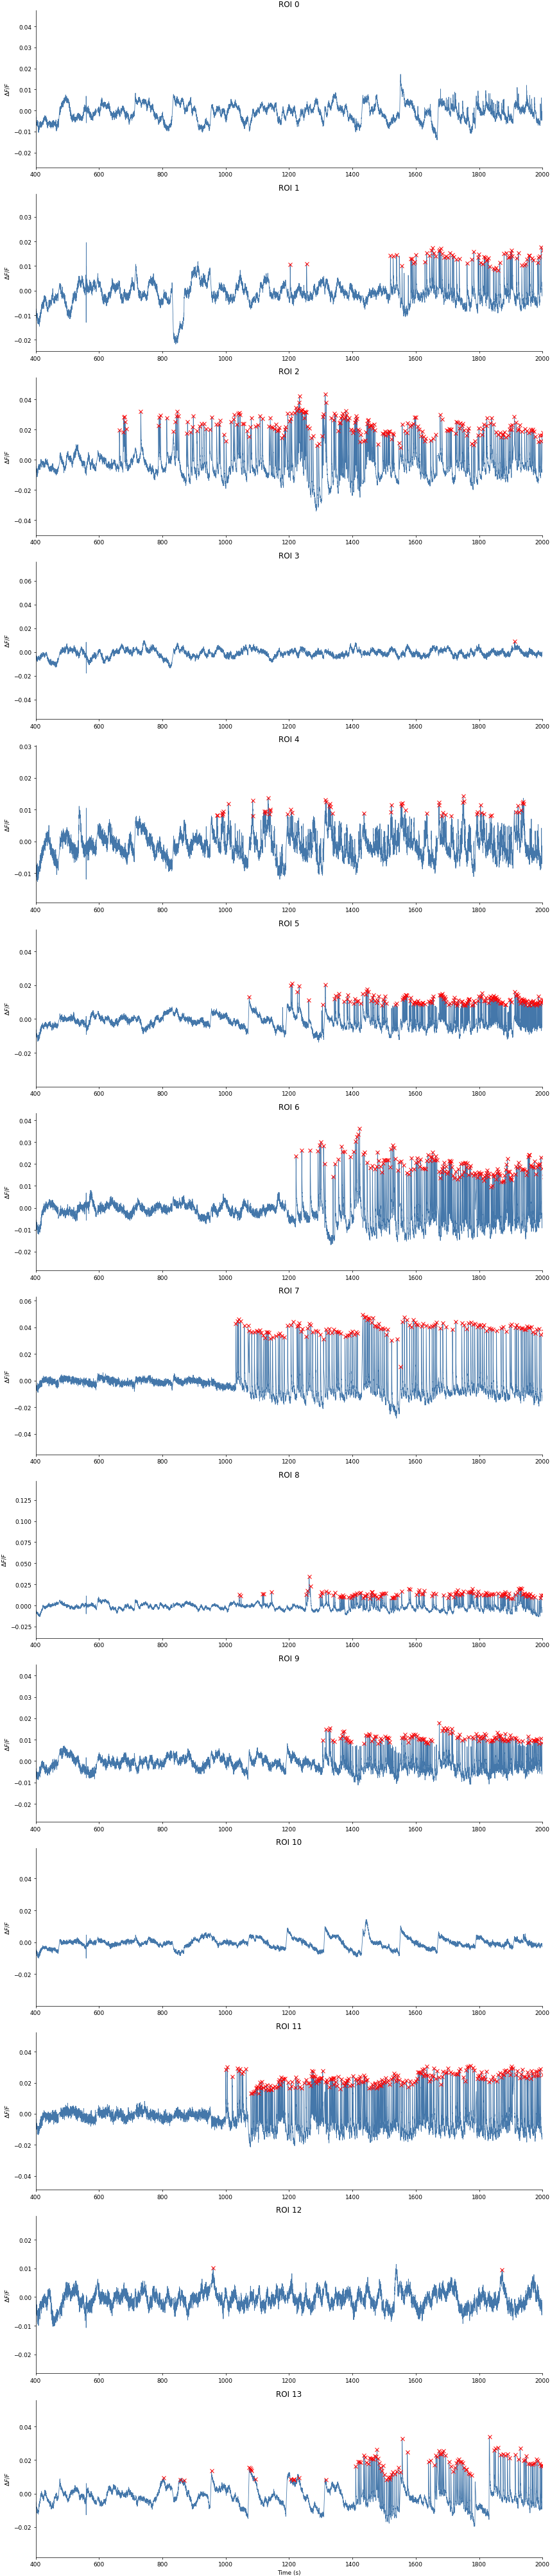

In [72]:
plt.close("all")
fig1, axes = dobj.plot_spikes(np.arange(dobj.dFF.shape[0]))
for ax in axes:
    ax.set_xlim(400, 2000)

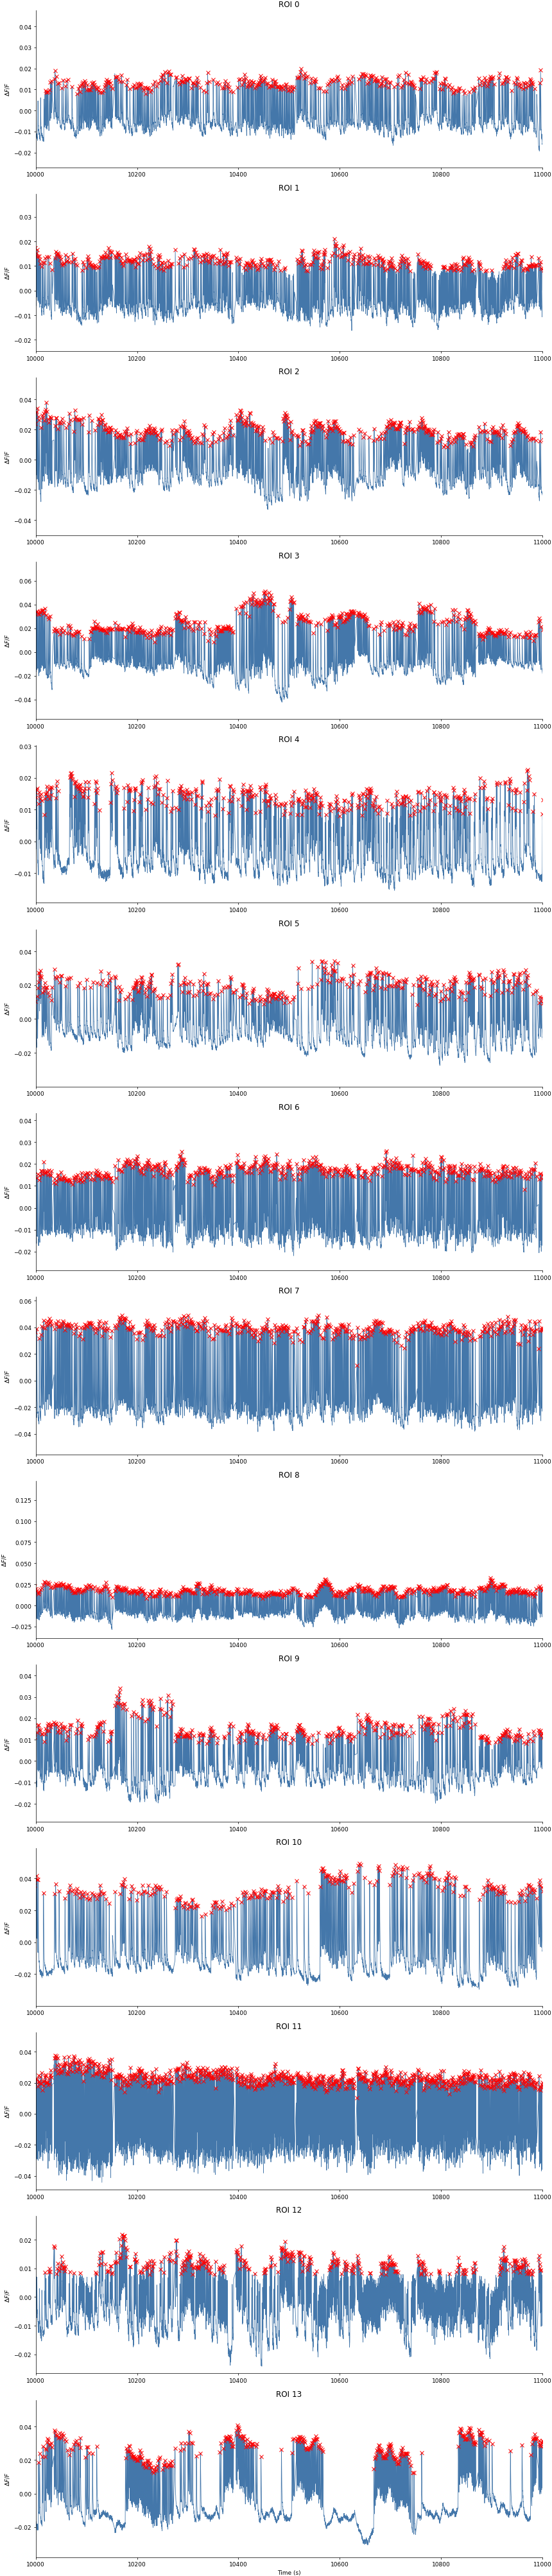

In [75]:
plt.close("all")
fig1, axes = dobj.plot_spikes(np.arange(dobj.dFF.shape[0]))
for ax in axes:
    ax.set_xlim(10000, 11000)

In [9]:
rois = [1, 2, 3,5, 6, 7, 8, 9, 11, 12, 13]

Align to first spike

In [10]:
offset_times = []
isi_threshold = 120
for idx, roi in enumerate(rois):
    roi_data = dobj.peaks_data.loc[roi]
#     print(roi_data["isi"].to_numpy() < isi_threshold)
    isi = roi_data["isi"].to_numpy()
    offset_idx = np.argwhere((isi< isi_threshold)&(np.roll(isi, 1) < isi_threshold)).ravel()[0]
    offset_times.append(roi_data["t"].iloc[offset_idx])

In [49]:
dobj.peaks_data.loc[rois].to_csv(os.path.join(output_datadir, "peaks_data.csv"))

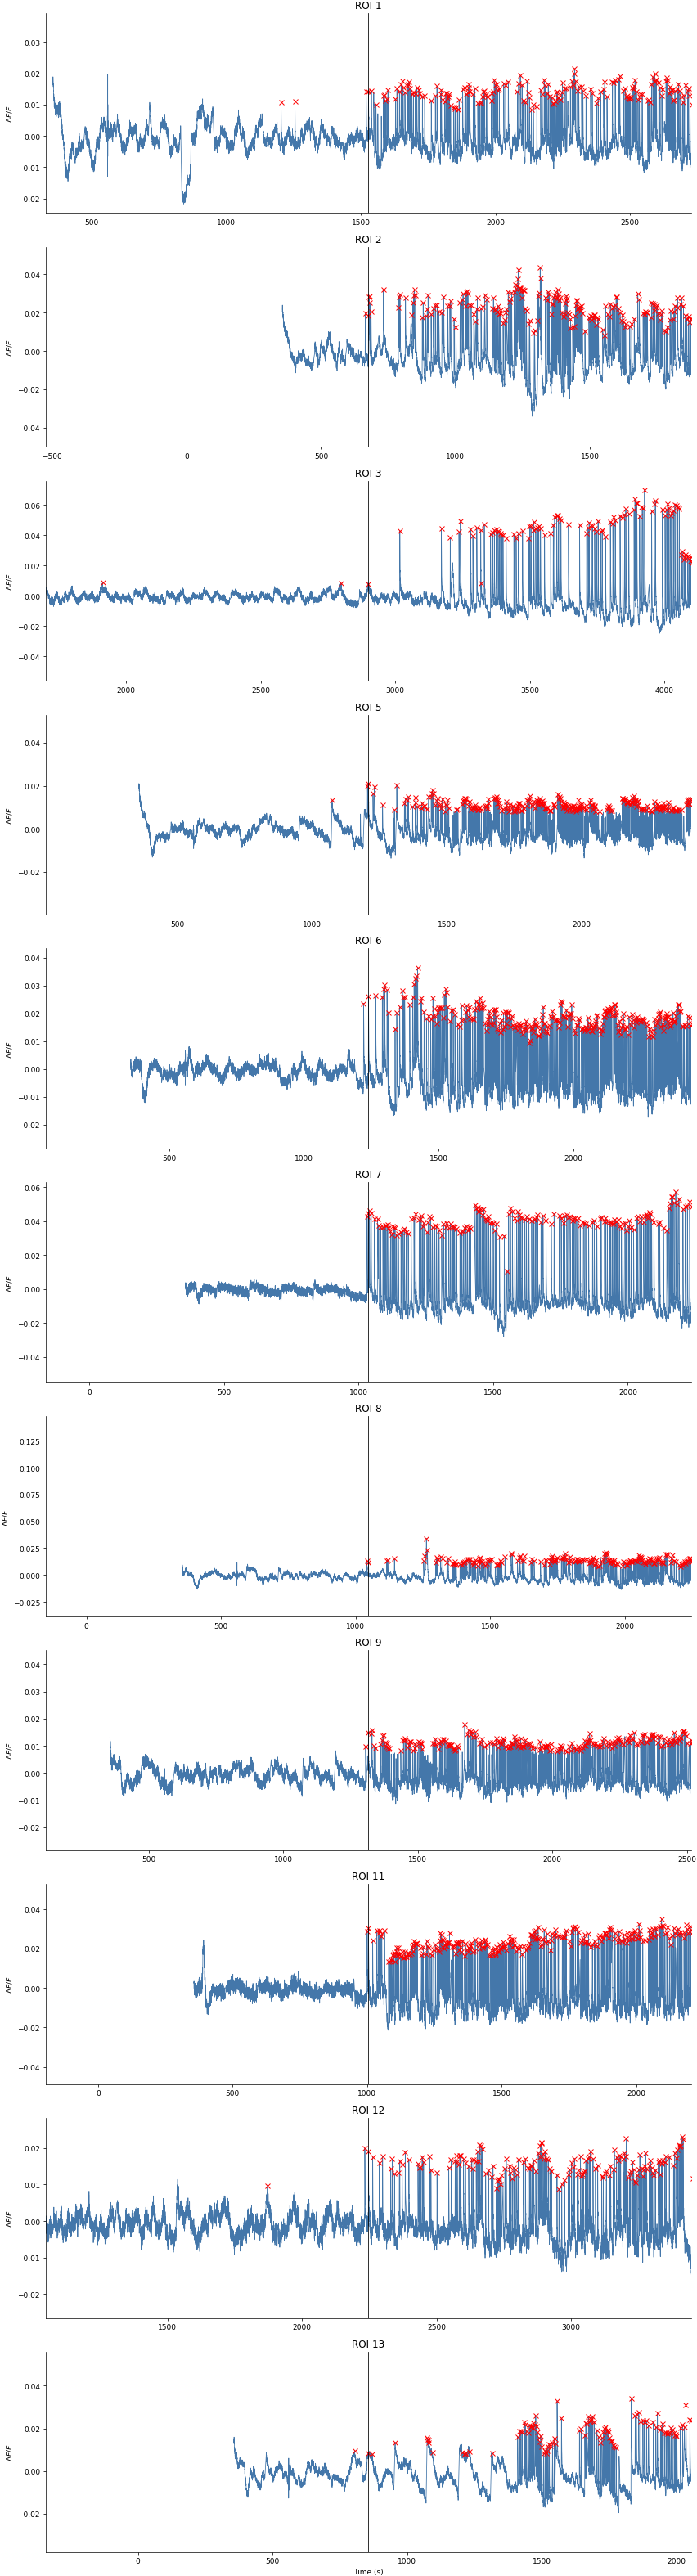

In [50]:
fig1, axes = dobj.plot_spikes(rois)
half_window = 1200
for idx, roi in enumerate(rois):
    axes[idx].set_xlim((offset_times[idx]-half_window, offset_times[idx]+half_window))
    axes[idx].axvline(offset_times[idx], color="black")

### Check frequency change over developmental time for selected embryos

In [51]:
window_size=1800

In [52]:
droi, dsta, dststd = dobj.get_windowed_peak_stats(window_size, overlap=0.9, sta_bounds=None, isi_stat_min_peaks=6)

Text(0, 0.5, 'Mean spike frequency (Hz)')

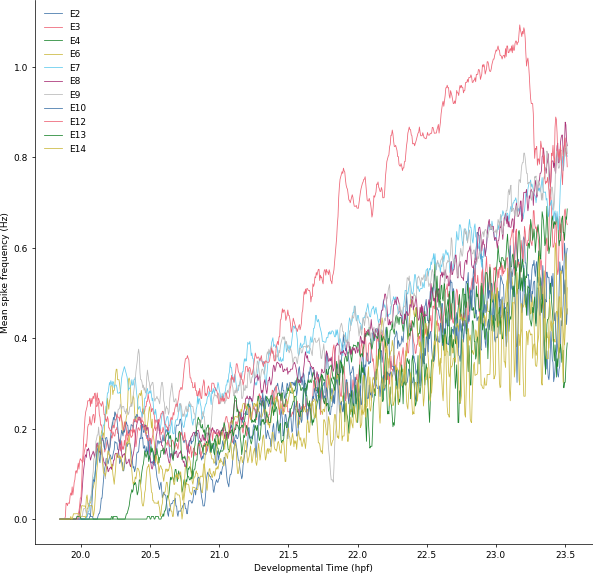

In [53]:
fig1, ax1 = plt.subplots(figsize=(10,10))
for roi in rois:
    e_data = droi.loc[roi]
    ax1.plot(e_data["hpf"], e_data["mean_freq"], label= "E%d" % (roi+1))
ax1.legend()
ax1.set_xlabel("Developmental Time (hpf)")
ax1.set_ylabel("Mean spike frequency (Hz)")

In [54]:
all_offsets = []
for idx, roi in enumerate(rois):
    e_data = droi.loc[roi]
    hpf = np.array(e_data["hpf"])
    all_offsets.append(np.argwhere(e_data["offset"].to_numpy() >= offset_times[idx]).ravel()[0])

/tmp/ipykernel_221272/3409768075.py:32: RuntimeWarning: Mean of empty slice
  axes[0].plot(np.nanmean(aligned_frequencies, axis=0))
/tmp/ipykernel_221272/3409768075.py:33: RuntimeWarning: Mean of empty slice
  axes[1].plot(np.nanmean(aligned_covs, axis=0))
/tmp/ipykernel_221272/3409768075.py:36: RuntimeWarning: Mean of empty slice
  "mean_freq": np.nanmean(aligned_frequencies, axis=0), "hpf":hpf,


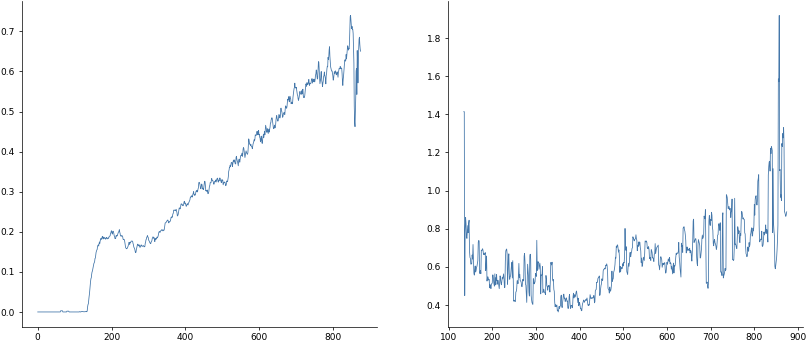

In [55]:
hpf = np.array(droi.loc[0]["hpf"])
hpf_offsets = hpf[all_offsets]
aligned_frequencies = np.nan*np.ones((len(rois), \
                                      hpf.shape[0]+max(all_offsets)))
aligned_proms = np.zeros((len(rois), hpf.shape[0]+max(all_offsets)))
aligned_covs = np.nan*np.ones((len(rois), \
                                      hpf.shape[0]+max(all_offsets)))
unaligned_frequencies = np.zeros((len(rois), hpf.shape[0]))
unaligned_covs = np.zeros((len(rois), hpf.shape[0]))
unaligned_proms = np.zeros((len(rois), hpf.shape[0]))
curr_row = 0
for roi in rois:
        e_data = droi.loc[roi]
        mean_freq = np.array(e_data["mean_freq"])
        cov = np.array(e_data["std_isi"]/e_data["mean_isi"])
        mean_prom = np.array(e_data["mean_prom"])
#         print(mean_freq.shape)
#         mean_freq = signal.filtfilt(b,a, mean_freq)
        start_idx = aligned_frequencies.shape[1] - e_data["hpf"].shape[0] - all_offsets[curr_row]
        
        unaligned_frequencies[curr_row, :] = mean_freq
        unaligned_proms[curr_row, :] = mean_prom
        unaligned_covs[curr_row,:] = cov
        
        aligned_frequencies[curr_row, start_idx:start_idx+e_data["hpf"].shape[0]] = \
            mean_freq
        aligned_proms[curr_row, start_idx:start_idx+e_data["hpf"].shape[0]] = mean_prom
        aligned_covs[curr_row, start_idx:start_idx+e_data["hpf"].shape[0]] = cov
        
        curr_row +=1
fig1, axes = plt.subplots(1,2, figsize=(14,6))
axes[0].plot(np.nanmean(aligned_frequencies, axis=0))
axes[1].plot(np.nanmean(aligned_covs, axis=0))
datamat = {"idx_offsets": all_offsets,
            "all_freqs":unaligned_frequencies, "all_freqs_aligned":aligned_frequencies,
            "mean_freq": np.nanmean(aligned_frequencies, axis=0), "hpf":hpf,
            "proms": unaligned_proms, "proms_aligned": aligned_proms, "covs":unaligned_covs, "covs_aligned": aligned_covs}
savemat(os.path.join(rootdir/"analysis"/"all_moments.mat"), datamat)
savemat(os.path.join(output_datadir/"all_moments.mat"), datamat)

In [56]:
moments = datamat
all_offsets = moments["idx_offsets"]
hpf = moments["hpf"].ravel()
print(all_offsets)
print(len(hpf))
moments["hpf_start"] = hpf[all_offsets].tolist()

[67, 19, 145, 49, 51, 39, 40, 55, 37, 108, 29]
749


In [57]:
hpf_starts = moments["hpf_start"]

In [58]:
hpf_starts

[20.17732026143799,
 19.942026143790873,
 20.559673202614558,
 20.08908496732032,
 20.09888888888895,
 20.040065359477172,
 20.044967320261488,
 20.118496732026212,
 20.030261437908543,
 20.378300653594902,
 19.991045751634022]

In [59]:
hpf_start = pd.DataFrame({"experiment": [expt_dir_name]*len(hpf_starts), 
             "condition": ["hcn4_mo"]* len(hpf_starts),
             "embryo": np.arange(len(hpf_starts)),
             "start_hpf": hpf_starts})

In [60]:
hpf_start.to_csv(output_datadir/"start_hpfs.csv", index=False)

Draw example traces for representative embryo

In [12]:
expt_info

start_time             file_name  offset        hpf
0     07:58:35    075835_p1_t1_p1_z1       0  19.750000
1     08:04:31    080431_p1_t1_p1_z1     356  19.848889
2     08:06:31    080631_p1_t2_p1_z1     476  19.882222
3     08:08:31    080831_p1_t3_p1_z1     596  19.915556
4     08:10:30    081030_p1_t4_p1_z1     715  19.948611
..         ...                   ...     ...        ...
108   11:37:38  113738_p1_t108_p1_z1   13143  23.400833
109   11:39:37  113937_p1_t109_p1_z1   13262  23.433889
110   11:41:37  114137_p1_t110_p1_z1   13382  23.467222
111   11:43:36  114336_p1_t111_p1_z1   13501  23.500278
112   11:45:36  114536_p1_t112_p1_z1   13621  23.533611

[113 rows x 4 columns]

In [51]:
rois

[1, 2, 3, 5, 6, 7, 8, 9, 11, 12, 13]

In [52]:
rep_embryo = 6
rep_embryo_idx = rois.index(rep_embryo)
rep_traces = [dobj.timepoint_to_filename(offset_times[rep_embryo_idx], time="s"),
              dobj.timepoint_to_filename(offset_times[rep_embryo_idx]+1800, time="s"),
              dobj.timepoint_to_filename(offset_times[rep_embryo_idx]+3600, time="s"),
              dobj.timepoint_to_filename(offset_times[rep_embryo_idx]+5400, time="s")]

In [49]:
re

11

$4\%$
$\Delta F/F$


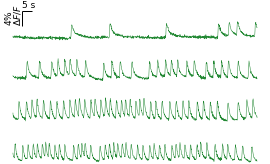

In [62]:
nrows = len(rep_traces)
ncols = 1
fig1, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 0.6*nrows))
axes = axes.ravel()
fs = 10.2
dt = 1/fs

for j, i in enumerate(rep_traces):
    q = pd.read_csv(rootdir/subfolder/"analysis"/f"{i}_traces.csv")
    F = q.set_index("region").loc[rep_embryo]["mean_intensity"].values
    dFF = traces.intensity_to_dff(F)
    axes[j].plot(np.arange(len(dFF))*dt, dFF, linewidth=0.5, color="C2")
    ylim = axes[j].get_ylim()
    axes[j].set_ylim(ylim[0], ylim[0]+ 0.07)
    axes[j].set_axis_off()
plt.tight_layout()

xlim = axes[0].get_xlim()
ylim = axes[0].get_ylim()

scalebar_params = {
    "corner_x": xlim[0]+10,
    "corner_y": ylim[1]*0.95,
    "ampl_scale": (ylim[1]-ylim[0])*0.5,
    "time_scale": 5,
    "fontsize": 9,
    "thickness": (ylim[1]-ylim[0])*0.02,
    "xlabel_offset_y": (ylim[1]-ylim[0])*0.12,
    "xlabel_offset_x": 0,
    "ylabel_offset_x": -9,
    "ylabel_offset_y": 0.007
    }
visualize.plot_scalebars(axes[0], scalebar_params, pct_f=True)
plt.savefig(output_datadir/"rep_traces_hcn4.svg", dpi=300, bbox_inches="tight")